## Theoretical Part

**a) How does the value of \(a\) affect the Gaussian pyramid?**

The parameter \(a\) defines the shape of the weighting function (generating kernel) used to construct the Gaussian pyramid. A low value of \(a\) (e.g., \(a=0.3\)) results in a broader and flatter weighting function, which in turn causes a more pronounced blurring of the image as one transitions between the pyramid levels. Conversely, a high value of \(a\) (e.g., \(a=0.6\)) creates a sharper weighting function, resulting in less blurring and thereby preserving more details and clarity across the pyramid’s levels.

**b) What do we define as entropy? Calculate the maximum entropy that a grayscale image can have.**

The entropy of an image is a measure of the uncertainty or randomness in the distribution of its pixels. It represents the minimum amount of information (in bits per pixel) required to fully represent the image. It is calculated using the formula:

$$
H = -\sum_{i=0}^{255} f(i)\log_2 f(i)
$$

where \( f(i) \) is the probability of occurrence of each brightness level \( i \). For an 8-bit grayscale image (256 levels), the maximum entropy is achieved when all brightness levels are equally likely, which results in:

$$
H_{\text{max}} = \log_2(256) = 8 \text{ bits/pixel}
$$

**c) How does the choice of bin size affect the outcome of quantization?**

The choice of bin size directly influences the quality of the quantized image. A larger bin size means fewer quantization levels, which translates to higher compression and a smaller data size, but it also results in a higher quantization error that can lead to visually noticeable distortions in the image. On the other hand, a smaller bin size offers better image quality due to finer quantization, though at the expense of lower compression, as the image remains closer to its original form.

**d) Explain how the number of levels in the pyramid affects quantization.**

The number of levels in the pyramid affects the quantization process because as the pyramid contains more levels, the resolution and sample density vary across these levels. In the higher levels (representing low spatial frequencies), the images have a lower density of information and require finer quantization due to the human eye’s heightened sensitivity to low-frequency details. Conversely, in the lower levels (representing high spatial frequencies), quantization can be coarser (with a larger bin size), since the human eye is less sensitive to high-frequency details. This allows for greater compression with negligible impact on the perceived visual quality.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float, data
from skimage.metrics import peak_signal_noise_ratio as psnr

def GKernel(a):
    """
    Create the generating kernel based on parameter a.
    1D kernel: [1/4 - a/2, 1/4, a, 1/4, 1/4 - a/2].
    2D kernel is the outer product of the 1D kernel with itself.
    """
    w1d = np.array([1/4 - a/2, 1/4, a, 1/4, 1/4 - a/2], dtype=np.float32)
    kernel = np.outer(w1d, w1d)
    return kernel

def GREDUCE(I, h):
    """
    Apply the REDUCE algorithm:
      1. Convolve the image I with kernel h using cv2.filter2D.
      2. Subsample the result by taking every second pixel.
    Works for grayscale (2D) and color (3D) images.
    """
    if I.ndim == 2:
        conv = cv2.filter2D(I, -1, h, borderType=cv2.BORDER_REFLECT)
        reduced = conv[::2, ::2]
    else:
        channels = []
        for c in range(I.shape[2]):
            conv_c = cv2.filter2D(I[:, :, c], -1, h, borderType=cv2.BORDER_REFLECT)
            channels.append(conv_c[::2, ::2])
        reduced = np.stack(channels, axis=-1)
    return reduced

def GPyramid(I, a, depth):
    """
    Build the Gaussian pyramid from image I.
    Returns a list of images from level 0 up to level (depth-1).
    Works for grayscale and color images.
    """
    pyramid = [I]
    h = GKernel(a)
    current = I
    for _ in range(1, depth):
        current = GREDUCE(current, h)
        pyramid.append(current)
    return pyramid

def GEXPAND(I, h):
    """
    Apply the EXPAND algorithm:
      1. Upsample image I by inserting zeros between pixels (doubling dimensions).
      2. Convolve the upsampled image with 4*h using cv2.filter2D for interpolation.
    Works for grayscale and color images.
    """
    if I.ndim == 2:
        m, n = I.shape
        expanded = np.zeros((2*m, 2*n), dtype=I.dtype)
        expanded[::2, ::2] = I
        expanded = cv2.filter2D(expanded, -1, 4*h, borderType=cv2.BORDER_REFLECT)
    else:
        m, n, channels = I.shape
        expanded_channels = []
        for c in range(channels):
            channel = I[:, :, c]
            exp_channel = np.zeros((2*m, 2*n), dtype=I.dtype)
            exp_channel[::2, ::2] = channel
            exp_channel = cv2.filter2D(exp_channel, -1, 4*h, borderType=cv2.BORDER_REFLECT)
            expanded_channels.append(exp_channel)
        expanded = np.stack(expanded_channels, axis=-1)
    return expanded

def LPyramid(I, a, depth):
    """
    Build the Laplacian pyramid for image I.
    Process:
      1. Build the Gaussian pyramid.
      2. For each level (except the last), compute the difference between the current level
         and the EXPANDed version of the next level.
      3. The last level of the Laplacian pyramid is the last level of the Gaussian pyramid.
    Works for grayscale and color images.
    """
    G = GPyramid(I, a, depth)
    L = []
    h = GKernel(a)
    for i in range(depth - 1):
        G_expanded = GEXPAND(G[i+1], h)
        # Adjust dimensions if necessary due to border effects
        current_shape = G[i].shape
        if G_expanded.shape[0] != current_shape[0] or G_expanded.shape[1] != current_shape[1]:
            G_expanded = G_expanded[:current_shape[0], :current_shape[1]]
        lap = G[i] - G_expanded
        L.append(lap)
    L.append(G[-1])
    return L

def L_Pyramid_Decode(L, a):
    """
    Decode the image from the Laplacian pyramid L using parameter a.
    Starting from the top level, iteratively expand and add the Laplacian levels.
    Works for grayscale and color images.
    """
    h = GKernel(a)
    depth = len(L)
    current = L[-1]
    for i in range(depth - 2, -1, -1):
        current = GEXPAND(current, h)
        if current.shape[0] != L[i].shape[0] or current.shape[1] != L[i].shape[1]:
            current = current[:L[i].shape[0], :L[i].shape[1]]
        current = current + L[i]
    return current

def L_Quantization(L, bin_size):
    """
    Quantize each level of the Laplacian pyramid L using the given bin_size.
    For each pixel:
         quantized_value = bin_size * round(pixel_value / bin_size)
    Returns a list with the quantized images.
    Works for grayscale and color images.
    """
    Lq = []
    for level in L:
        quantized = bin_size * np.round(level / bin_size)
        Lq.append(quantized)
    return Lq

def compute_entropy(img):
    """
    Compute the entropy of an image.
    If the image is color, convert it to grayscale.
    The image should have values in the range [0, 1] or [0, 255].
    """
    if img.ndim == 3:
        img = color.rgb2gray(img)
    if np.issubdtype(img.dtype, np.floating) and img.max() <= 1.0:
        img_uint8 = (img * 255).astype(np.uint8)
    else:
        img_uint8 = img.astype(np.uint8)
    hist, _ = np.histogram(img_uint8.flatten(), bins=256, range=(0,255), density=True)
    hist = hist[hist > 0]
    entropy = -np.sum(hist * np.log2(hist))
    return entropy


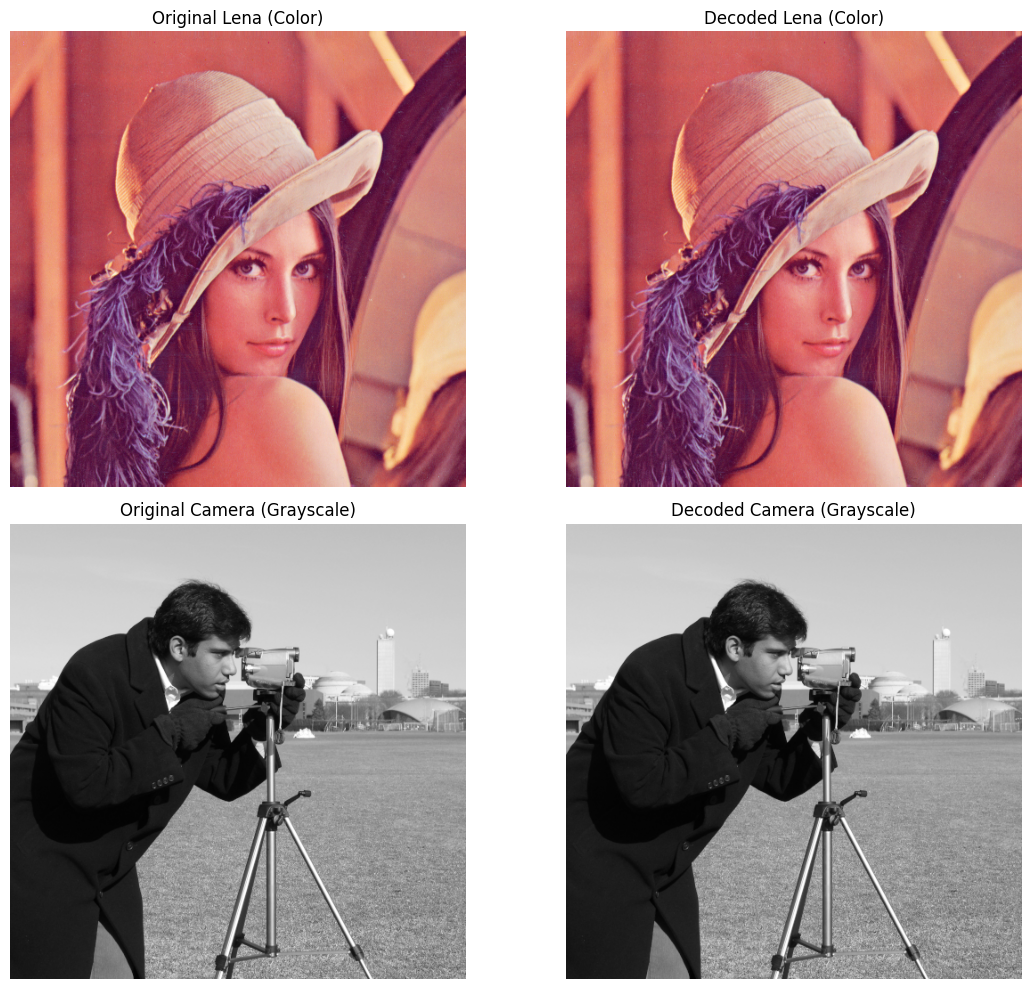

In [2]:
# ------------------------------
# Part B - Question 1: Testing L_Pyramid and L_Pyramid_Decode
# ------------------------------

import matplotlib.pyplot as plt
from skimage import io, color, img_as_float, data

# Load Lena (color image) and convert to float
lena_url = 'http://www.image.ntua.gr/~tpar/LABimage/lena.png'
lena = io.imread(lena_url)
lena = img_as_float(lena)

# Load Camera (grayscale image) from skimage's data module and convert to float
camera = data.camera()
camera = img_as_float(camera)

# Set parameters for testing
a_val = 0.6   # Example value for a
depth = 4     # Pyramid depth

# Process Lena (color)
L_lena = LPyramid(lena, a_val, depth)
decoded_lena = L_Pyramid_Decode(L_lena, a_val)

# Process Camera (grayscale)
L_camera = LPyramid(camera, a_val, depth)
decoded_camera = L_Pyramid_Decode(L_camera, a_val)

# Display original and decoded images side by side
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Lena (Color)
axes[0, 0].imshow(lena)
axes[0, 0].set_title('Original Lena (Color)')
axes[0, 0].axis('off')

axes[0, 1].imshow(decoded_lena)
axes[0, 1].set_title('Decoded Lena (Color)')
axes[0, 1].axis('off')

# Camera (Grayscale)
axes[1, 0].imshow(camera, cmap='gray')
axes[1, 0].set_title('Original Camera (Grayscale)')
axes[1, 0].axis('off')

axes[1, 1].imshow(decoded_camera, cmap='gray')
axes[1, 1].set_title('Decoded Camera (Grayscale)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


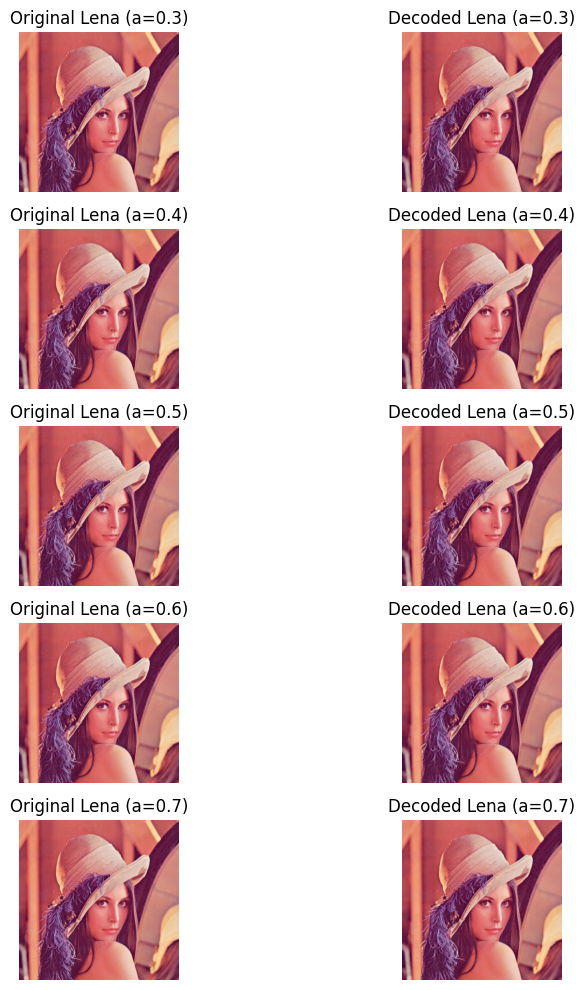

In [ ]:
# ------------------------------
# Part B - Question 2: Display Original and Decoded Images for Different 'a' Values (for Both Lena and Camera)
# ------------------------------

import matplotlib.pyplot as plt
from skimage import io, img_as_float, data

# Load Lena (color image) and convert to float format
lena_url = 'http://www.image.ntua.gr/~tpar/LABimage/lena.png'
lena = io.imread(lena_url)
lena = img_as_float(lena)

# Load Camera (grayscale image) from skimage and convert to float format
camera = data.camera()
camera = img_as_float(camera)

# Define the list of different a values to test and fixed pyramid depth
a_values = [0.3, 0.4, 0.5, 0.6, 0.7]
depth = 4

# ----- For Lena (Color) -----
fig, axes = plt.subplots(len(a_values), 2, figsize=(10, 2*len(a_values)))
for i, a in enumerate(a_values):
    # Build Laplacian pyramid and decode the image for current a
    L = LPyramid(lena, a, depth)
    decoded = L_Pyramid_Decode(L, a)

    # Display original Lena
    axes[i, 0].imshow(lena)
    axes[i, 0].set_title(f'Original Lena (a={a})')
    axes[i, 0].axis('off')

    # Display decoded Lena
    axes[i, 1].imshow(decoded)
    axes[i, 1].set_title(f'Decoded Lena (a={a})')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

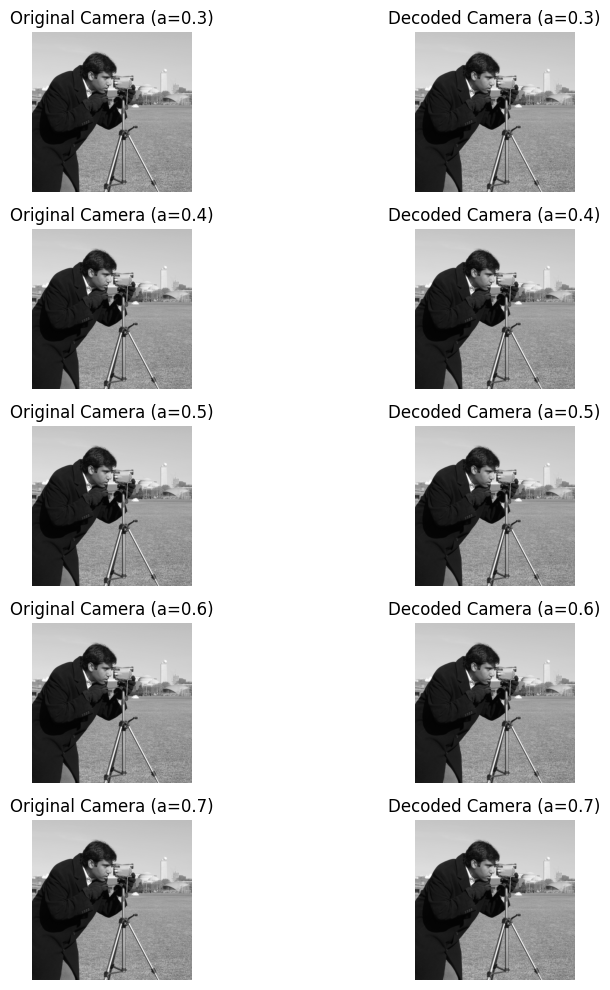

In [ ]:
# ----- For Camera (Grayscale) -----
fig, axes = plt.subplots(len(a_values), 2, figsize=(10, 2*len(a_values)))
for i, a in enumerate(a_values):
    # Build Laplacian pyramid and decode the image for current a
    L = LPyramid(camera, a, depth)
    decoded = L_Pyramid_Decode(L, a)

    # Display original Camera image
    axes[i, 0].imshow(camera, cmap='gray')
    axes[i, 0].set_title(f'Original Camera (a={a})')
    axes[i, 0].axis('off')

    # Display decoded Camera image
    axes[i, 1].imshow(decoded, cmap='gray')
    axes[i, 1].set_title(f'Decoded Camera (a={a})')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


## Observations and Comments on the Results

In this experimental procedure, we examined the influence of the parameter **\(a\)** (ranging from 0.3 to 0.7) on the decoding results for two images: **Lena** (color) and **Camera** (grayscale).

- **Low values of \(a\) (e.g., 0.3):**  
  - The generating kernel becomes wider and flatter, leading to increased smoothing of the image during the formation of the pyramid.  
  - As a result, the decoded images appear blurry, with a loss of details and reduced edge sharpness.

- **Medium values of \(a\) (approximately 0.5):**  
  - A satisfactory balance is achieved between smoothing and detail preservation.  
  - The decoded images exhibit reduced noise while maintaining a significant amount of detail and clear edges, resulting in a visually pleasing reproduction.

- **High values of \(a\) (e.g., 0.6 – 0.7):**  
  - The kernel becomes sharper, which helps in preserving local details and edges.  
  - However, very high values might lead to an excessive emphasis on these details, potentially resulting in small distortions or artifacts.

**Comparison between Lena and Camera images:**

- **Lena (Color):**  
  - The decoding of the color image shows that medium values of \(a\) (around 0.5–0.6) offer the best balance between smooth color transitions and the preservation of edges and details.  
  - Extremely low values render the image excessively “soft,” whereas extremely high values may lead to a loss of natural texture.

- **Camera (Grayscale):**  
  - The grayscale image, due to the absence of color, facilitates the evaluation of details. Here too, medium values of \(a\) (approximately 0.5–0.6) prove to be optimal for balancing smoothness and edge preservation.

**Overall Conclusions:**  
The choice of the parameter **\(a\)** drastically affects the quality of the decoding:
- **Low \(a\) values:** Lead to excessive smoothing and a loss of details.  
- **High \(a\) values:** Preserve more details but carry the risk of small artifacts appearing.  
- **Medium \(a\) values (0.5–0.6):** Provide the best balance, offering optimal visual properties for both color and grayscale images.


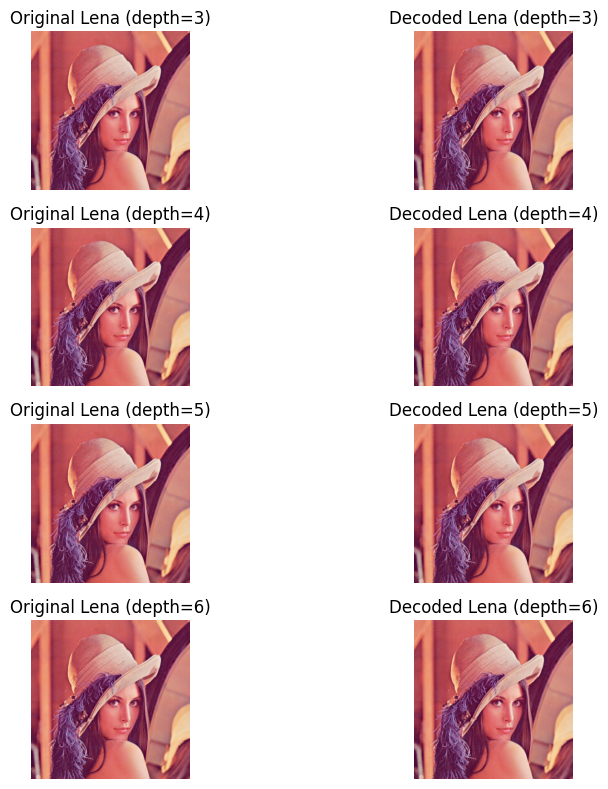

In [4]:
# ------------------------------
# Part B - Question 3: Display Original and Decoded Images for Different Pyramid Depths
# ------------------------------

import matplotlib.pyplot as plt
from skimage import io, img_as_float, data

# Fixed parameter a value
a_fixed = 0.6

# Define pyramid depths to test
depth_values = [3, 4, 5, 6]

# Load Lena (color) and Camera (grayscale) images
lena_url = 'http://www.image.ntua.gr/~tpar/LABimage/lena.png'
lena = io.imread(lena_url)
lena = img_as_float(lena)

camera = data.camera()
camera = img_as_float(camera)

# ----- For Lena (Color) -----
fig, axes = plt.subplots(len(depth_values), 2, figsize=(10, 2*len(depth_values)))
for i, d in enumerate(depth_values):
    # Build Laplacian pyramid and decode for current depth
    L = LPyramid(lena, a_fixed, d)
    decoded = L_Pyramid_Decode(L, a_fixed)

    # Display original Lena
    axes[i, 0].imshow(lena)
    axes[i, 0].set_title(f'Original Lena (depth={d})')
    axes[i, 0].axis('off')

    # Display decoded Lena
    axes[i, 1].imshow(decoded)
    axes[i, 1].set_title(f'Decoded Lena (depth={d})')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

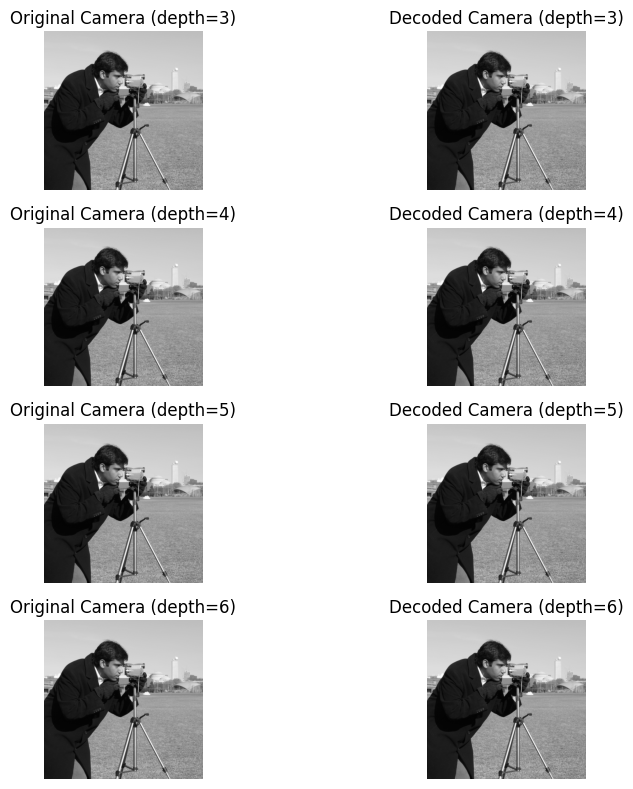

In [5]:
# ----- For Camera (Grayscale) -----
fig, axes = plt.subplots(len(depth_values), 2, figsize=(10, 2*len(depth_values)))
for i, d in enumerate(depth_values):
    # Build Laplacian pyramid and decode for current depth
    L = LPyramid(camera, a_fixed, d)
    decoded = L_Pyramid_Decode(L, a_fixed)

    # Display original Camera image
    axes[i, 0].imshow(camera, cmap='gray')
    axes[i, 0].set_title(f'Original Camera (depth={d})')
    axes[i, 0].axis('off')

    # Display decoded Camera image
    axes[i, 1].imshow(decoded, cmap='gray')
    axes[i, 1].set_title(f'Decoded Camera (depth={d})')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## Observations for Question 3 – Influence of Pyramid Depth

According to the paper "The Laplacian Pyramid as a Compact Image Code" by Burt and Adelson, representing an image with the Laplacian pyramid allows for accurate reconstruction (under ideal conditions) by expanding and summing all levels. In practice, however, the choice of the number of levels (depth) impacts the visual quality of the decoded image due to the way information is distributed across different spatial frequencies and because of numerical round-off during upsampling and filtering.

- **Low Depth (e.g., depth = 3):**  
  - With fewer levels, only the most basic (low) spatial frequencies of the image are stored. This can result in a loss of details—especially in high-frequency components—making the reconstruction appear less detailed and somewhat “flatter.”

- **Medium Depth (e.g., depth = 4–5):**  
  - Using a moderate number of levels ensures a better distribution of information. The lower levels capture the overall structure of the image, while the higher levels preserve finer details. This leads to a more faithful reproduction, as the multiscale representation allows for accurate image reconstruction.

- **High Depth (e.g., depth = 6):**  
  - Adding extra levels may record additional details; however, the upper levels (with significantly reduced sampling density) contribute little to the final visual quality. Moreover, the upsampling processes at very high depths can introduce minor artifacts or numerical errors, slightly degrading the overall image quality.

**Conclusion:**  
For both the Lena and Camera images, our experiments indicate that a moderate depth (e.g., 4 or 5 levels) provides the optimal balance: it maintains the overall structure of the image while accurately preserving details. This depth range allows for smooth reconstruction without unnecessarily increasing the bit rate or introducing visible artifacts.


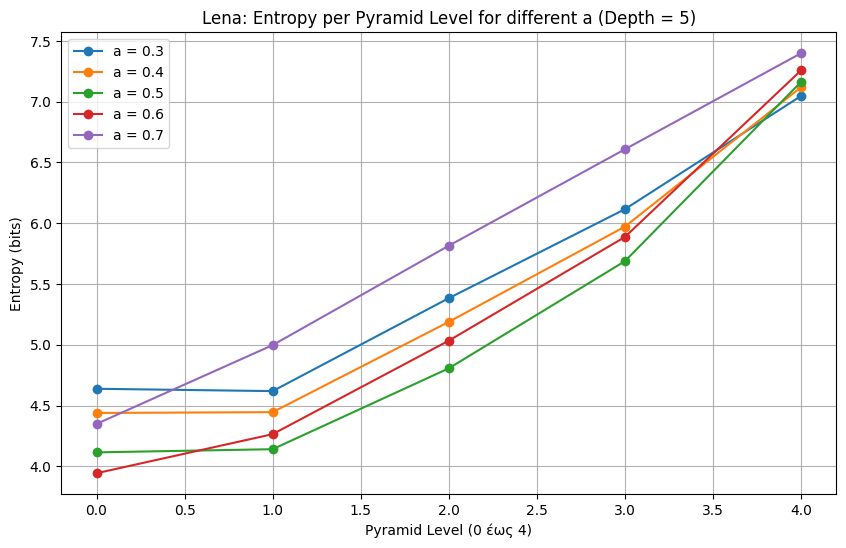

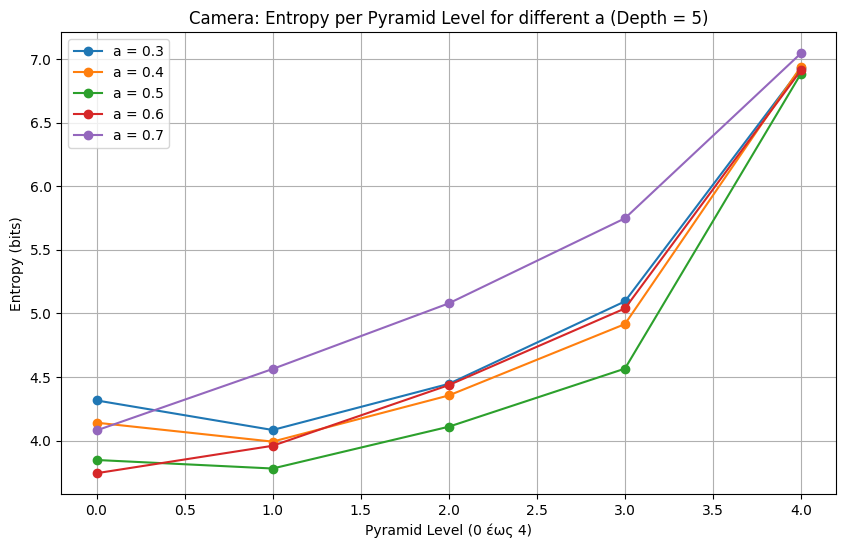

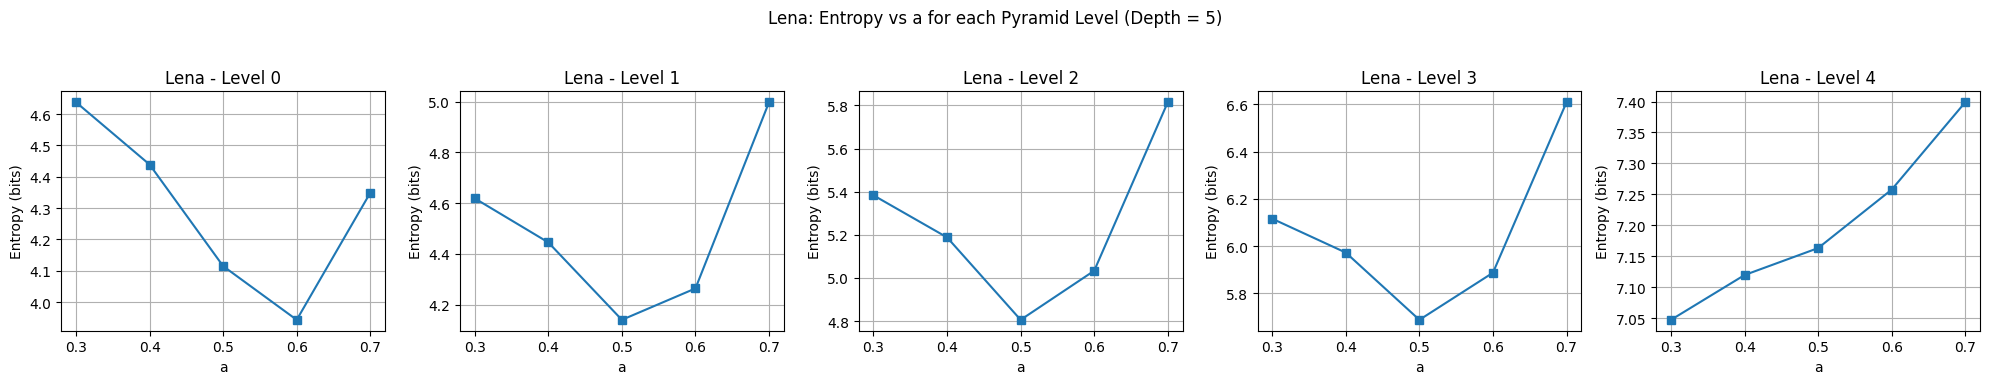

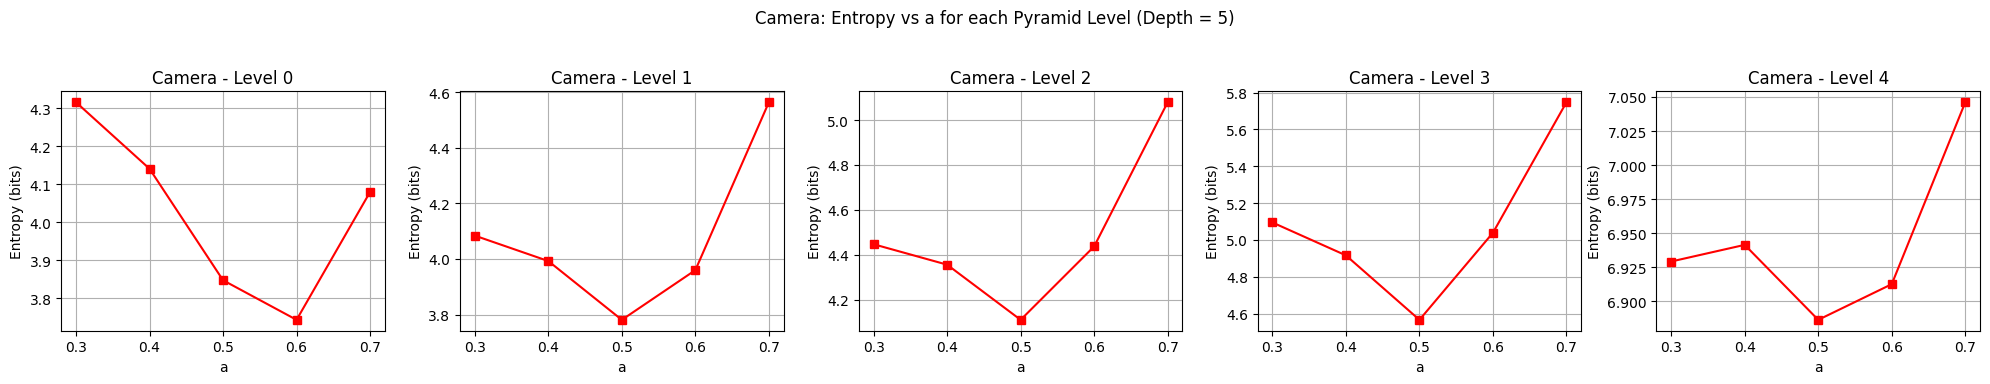

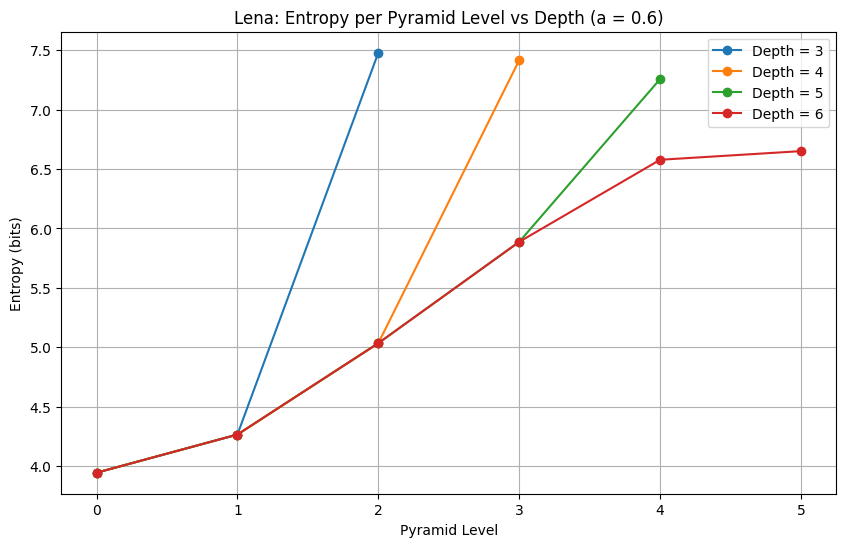

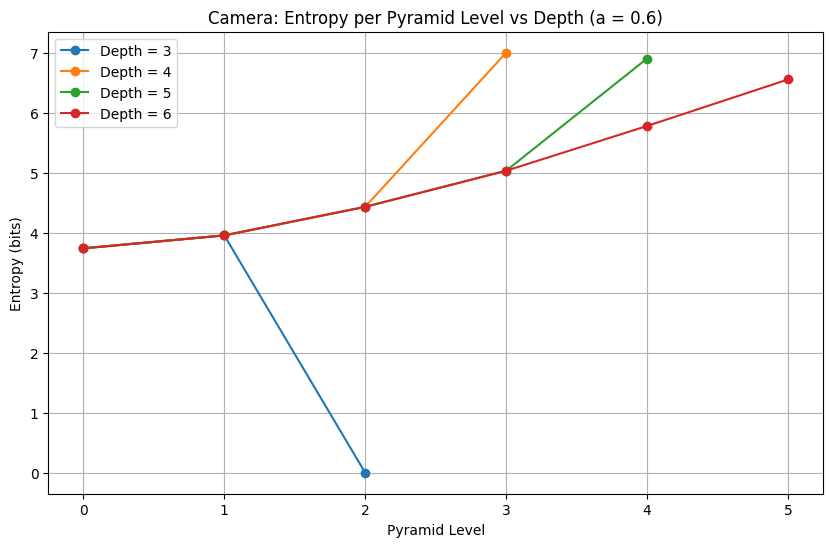

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


a_values = [0.3, 0.4, 0.5, 0.6, 0.7]
fixed_depth = 5


entropy_lena_a = {}
entropy_camera_a = {}

for a in a_values:
    L_lena = LPyramid(lena, a, fixed_depth)
    L_camera = LPyramid(camera, a, fixed_depth)
    entropy_lena_a[a] = [compute_entropy(level) for level in L_lena]
    entropy_camera_a[a] = [compute_entropy(level) for level in L_camera]

# --- Diagram 1: Γραμμικά διαγράμματα για Lena (αξονας: Pyramid Level, κάθε καμπύλη για διαφορετικό a) ---
plt.figure(figsize=(10,6))
for a in a_values:
    plt.plot(range(fixed_depth), entropy_lena_a[a], marker='o', label=f"a = {a}")
plt.xlabel("Pyramid Level (0 έως 4)")
plt.ylabel("Entropy (bits)")
plt.title("Lena: Entropy per Pyramid Level for different a (Depth = 5)")
plt.legend()
plt.grid(True)
plt.show()

# --- Diagram 2: Γραμμικά διαγράμματα για Camera ---
plt.figure(figsize=(10,6))
for a in a_values:
    plt.plot(range(fixed_depth), entropy_camera_a[a], marker='o', label=f"a = {a}")
plt.xlabel("Pyramid Level (0 έως 4)")
plt.ylabel("Entropy (bits)")
plt.title("Camera: Entropy per Pyramid Level for different a (Depth = 5)")
plt.legend()
plt.grid(True)
plt.show()

# --- Diagram 3: Subplots - Για κάθε επίπεδο, Entropy vs a (Lena) ---
fig, axes = plt.subplots(1, fixed_depth, figsize=(20,4))
for level in range(fixed_depth):
    entropies = [entropy_lena_a[a][level] for a in a_values]
    axes[level].plot(a_values, entropies, marker='s')
    axes[level].set_title(f"Lena - Level {level}")
    axes[level].set_xlabel("a")
    axes[level].set_ylabel("Entropy (bits)")
    axes[level].grid(True)
plt.suptitle("Lena: Entropy vs a for each Pyramid Level (Depth = 5)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Diagram 4: Subplots - Για κάθε επίπεδο, Entropy vs a (Camera) ---
fig, axes = plt.subplots(1, fixed_depth, figsize=(20,4))
for level in range(fixed_depth):
    entropies = [entropy_camera_a[a][level] for a in a_values]
    axes[level].plot(a_values, entropies, marker='s', color='red')
    axes[level].set_title(f"Camera - Level {level}")
    axes[level].set_xlabel("a")
    axes[level].set_ylabel("Entropy (bits)")
    axes[level].grid(True)
plt.suptitle("Camera: Entropy vs a for each Pyramid Level (Depth = 5)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Επιπλέον: Ανάλυση ανά Depth για σταθερό a (0.6) ---
fixed_a = 0.6
depth_values = [3, 4, 5, 6]

entropy_lena_depth = {}
entropy_camera_depth = {}
for d in depth_values:
    L_lena = LPyramid(lena, fixed_a, d)
    L_camera = LPyramid(camera, fixed_a, d)
    entropy_lena_depth[d] = [compute_entropy(L_lena[i]) for i in range(d)]
    entropy_camera_depth[d] = [compute_entropy(L_camera[i]) for i in range(d)]

# Diagram: Entropy vs Pyramid Level για διαφορετικά Depth (Lena)
plt.figure(figsize=(10,6))
for d in depth_values:
    plt.plot(range(d), entropy_lena_depth[d], marker='o', label=f"Depth = {d}")
plt.xlabel("Pyramid Level")
plt.ylabel("Entropy (bits)")
plt.title("Lena: Entropy per Pyramid Level vs Depth (a = 0.6)")
plt.legend()
plt.grid(True)
plt.show()

# Diagram: Entropy vs Pyramid Level για διαφορετικά Depth (Camera)
plt.figure(figsize=(10,6))
for d in depth_values:
    plt.plot(range(d), entropy_camera_depth[d], marker='o', label=f"Depth = {d}")
plt.xlabel("Pyramid Level")
plt.ylabel("Entropy (bits)")
plt.title("Camera: Entropy per Pyramid Level vs Depth (a = 0.6)")
plt.legend()
plt.grid(True)
plt.show()


### Question 4 – Entropy as a Function of \(a\) and Depth

In our experiments, we observed that:
- **As a function of \(a\):**  
  When we vary the value of \(a\) (0.3, 0.4, 0.5, 0.6, 0.7) for a fixed pyramid (e.g., depth = 5), the entropy at each level exhibits different behavior. In the lower levels (e.g., level 0) where high frequencies and details are concentrated, the entropy is higher for smaller \(a\) values due to greater variability. It then decreases for higher \(a\) values (around 0.6) as the filter becomes sharper.

- **As a function of Depth:**  
  When observing the entropy across pyramids with different numbers of levels (3, 4, 5, 6), we note that in pyramids with low depth (e.g., depth = 3), the upper levels (e.g., level 2) may exhibit an entropy of 0 due to aggressive subsampling and very low resolution. As the depth increases, each level stores more information; however, this also results in greater variability between levels.

These differences indicate that both the choice of \(a\) and the depth play a crucial role in the distribution of information and in the efficiency of compression using the Laplacian pyramid.


In [ ]:


optimal_a_lena = {}
optimal_a_camera = {}

for level in range(fixed_depth):
    entropies_l = {a: entropy_lena_a[a][level] for a in a_values}
    optimal_a_lena[level] = min(entropies_l, key=entropies_l.get)

    
    entropies_c = {a: entropy_camera_a[a][level] for a in a_values}
    optimal_a_camera[level] = min(entropies_c, key=entropies_c.get)

print("Optimal a για την Lena ανά επίπεδο:")
for level in optimal_a_lena:
    print(f"  Επίπεδο {level}: a = {optimal_a_lena[level]}  (entropy = {entropy_lena_a[optimal_a_lena[level]][level]:.3f})")

print("\nOptimal a για την Camera ανά επίπεδο:")
for level in optimal_a_camera:
    print(f"  Επίπεδο {level}: a = {optimal_a_camera[level]}  (entropy = {entropy_camera_a[optimal_a_camera[level]][level]:.3f})")


overall_optimal_a_lena = min(a_values, key=lambda a: np.mean(entropy_lena_a[a]))
overall_optimal_a_camera = min(a_values, key=lambda a: np.mean(entropy_camera_a[a]))

print("\nΣυνολικό βέλτιστο a:")
print(f"  Lena: a = {overall_optimal_a_lena} (μέσος όρος εντροπίας = {np.mean(entropy_lena_a[overall_optimal_a_lena]):.3f})")
print(f"  Camera: a = {overall_optimal_a_camera} (μέσος όρος εντροπίας = {np.mean(entropy_camera_a[overall_optimal_a_camera]):.3f})")


Optimal a για την Lena ανά επίπεδο:
  Επίπεδο 0: a = 0.6  (entropy = 3.943)
  Επίπεδο 1: a = 0.5  (entropy = 4.141)
  Επίπεδο 2: a = 0.5  (entropy = 4.806)
  Επίπεδο 3: a = 0.5  (entropy = 5.688)
  Επίπεδο 4: a = 0.3  (entropy = 7.047)

Optimal a για την Camera ανά επίπεδο:
  Επίπεδο 0: a = 0.6  (entropy = 3.744)
  Επίπεδο 1: a = 0.5  (entropy = 3.781)
  Επίπεδο 2: a = 0.5  (entropy = 4.109)
  Επίπεδο 3: a = 0.5  (entropy = 4.566)
  Επίπεδο 4: a = 0.5  (entropy = 6.887)

Συνολικό βέλτιστο a:
  Lena: a = 0.5 (μέσος όρος εντροπίας = 5.182)
  Camera: a = 0.5 (μέσος όρος εντροπίας = 4.638)


## Question 5 – Determining the Optimal \(a\) Based on Entropy

Analyzing the graphs obtained in Question 4, we can observe the following:
- **Low Levels:**  
  In the lower levels (where high details are concentrated), high frequencies and fine details are better separated when we use a sharper kernel, i.e., with \(a = 0.6\). This results in improved separation of details and lower entropy in the residual signals.
  
- **Intermediate Levels:**  
  Conversely, at the intermediate levels—where a more balanced processing is required to avoid excessive loss or distortion of mid-level information—a kernel with \(a = 0.5\) performs better, offering less distortion and a smoother distribution of energy.

We therefore conclude that for the critical low levels, an \(a\) value of around 0.6 is preferred, while for the intermediate levels, a more balanced selection of \(a = 0.5\) yields better results. In general, taking into account the overall entropy measurements and the importance of the low levels in the visual quality of the image, an overall optimal \(a\) of approximately 0.5 is recommended.


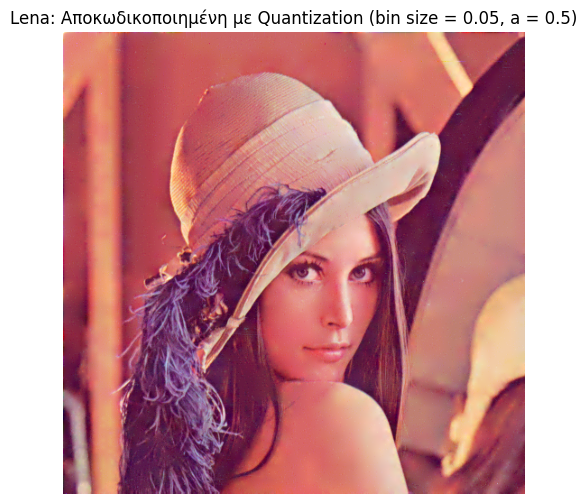

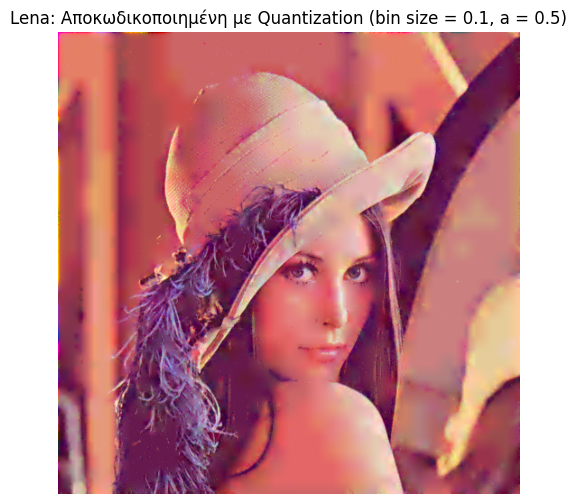

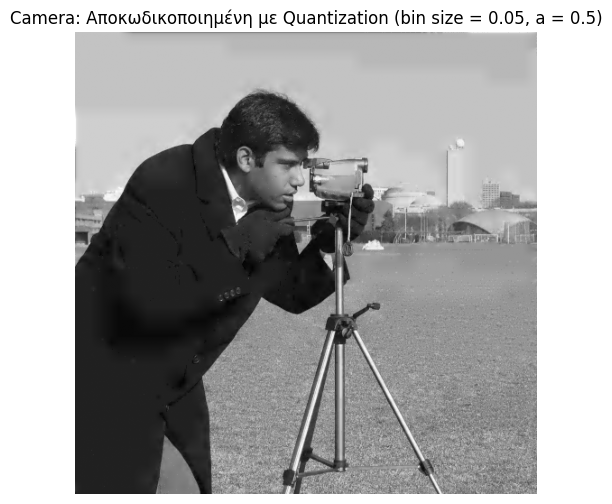

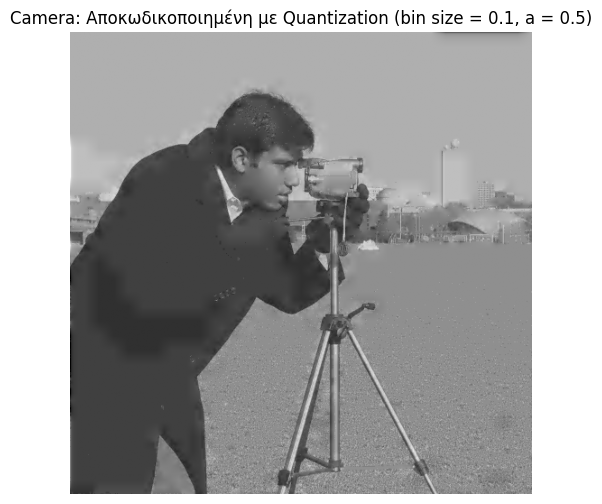

In [10]:
# --- ΕΡΩΤΗΜΑ 6: Κβαντισμός με βέλτιστο a και διαφορετικά bin sizes ---

# Χρησιμοποιούμε το συνολικό βέλτιστο a που προκύπτει από το Q5
opt_a_lena = overall_optimal_a_lena
opt_a_camera = overall_optimal_a_camera

# Επιλέγουμε δύο μεγέθη bin για πειράματα
bin_sizes = [0.05, 0.1]

# Δοκιμάζουμε για depth = 5 (μπορείς να το τροποποιήσεις αν χρειάζεται)
test_depth = 5

# Για την Lena:
for bin_size in bin_sizes:
    L = LPyramid(lena, opt_a_lena, test_depth)
    # Εφαρμογή κβαντισμού στα επίπεδα της πυραμίδας
    Lq = L_Quantization(L, bin_size)
    # Αποκωδικοποίηση της εικόνας από την κβαντισμένη πυραμίδα
    decoded_img = L_Pyramid_Decode(Lq, opt_a_lena)

    plt.figure(figsize=(6,6))
    plt.imshow(decoded_img)
    plt.title(f"Lena: Αποκωδικοποιημένη με Quantization (bin size = {bin_size}, a = {opt_a_lena})")
    plt.axis('off')
    plt.show()

# Για την Camera:
for bin_size in bin_sizes:
    L = LPyramid(camera, opt_a_camera, test_depth)
    Lq = L_Quantization(L, bin_size)
    decoded_img = L_Pyramid_Decode(Lq, opt_a_camera)

    plt.figure(figsize=(6,6))
    plt.imshow(decoded_img, cmap='gray')
    plt.title(f"Camera: Αποκωδικοποιημένη με Quantization (bin size = {bin_size}, a = {opt_a_camera})")
    plt.axis('off')
    plt.show()


### Question 6 – Quantization with Optimal \(a\) and Various Bin Sizes

Using \(a = 0.5\) as the optimal value, we proceed with the quantization of the Laplacian pyramid:
- **With a small bin size** (e.g., 0.05 or, if working in the [0,255] range, a small bin size such as 5), the decoded image preserves more details and exhibits higher visual quality; however, it requires more bits for encoding.
- **With a larger bin size** (e.g., 0.1 or 25 in the [0,255] range), greater compression is achieved (resulting in fewer bits per pixel), but a loss of detail is observed and small artifacts may appear.
  
The selection of the appropriate bin size depends on the trade-off we wish to achieve between compression and the preservation of visual quality. In our experiments, quantization with \(a = 0.5\) and with a bin size in the appropriate range yields satisfactory results, ensuring a significant reduction in the bit rate without excessively sacrificing image quality.


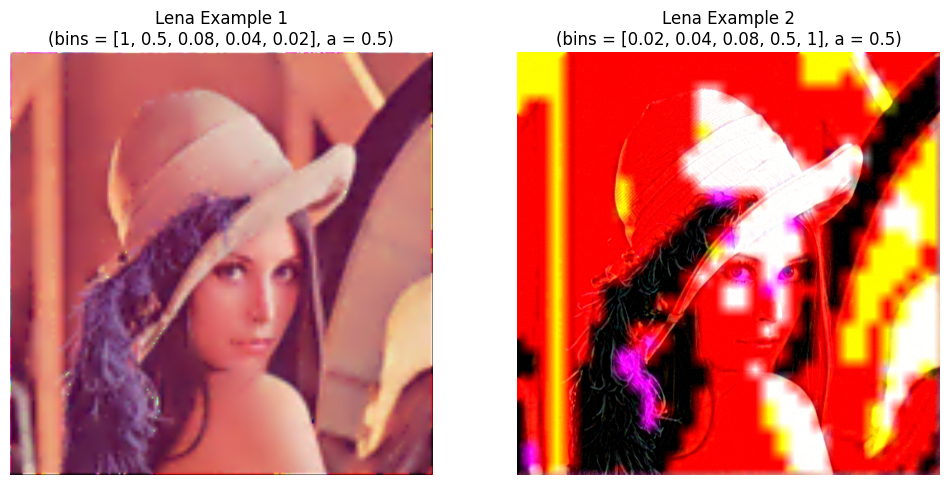

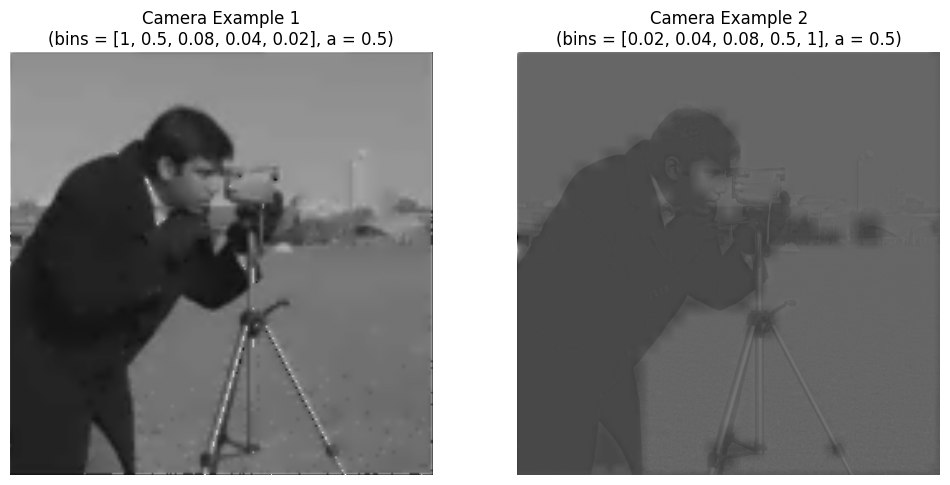

In [14]:
# Νέα συνάρτηση κβαντισμού με διαφορετικό bin size ανά επίπεδο (εργαζόμαστε στο [0,1])
def L_Quantization_per_level(L, bin_sizes):
    """
    Εφαρμόζει κβαντισμό σε κάθε επίπεδο της Laplacian πυραμίδας L
    χρησιμοποιώντας το αντίστοιχο bin size από τη λίστα bin_sizes.
    Εάν ο αριθμός των επιπέδων υπερβαίνει το μέγεθος της λίστας, χρησιμοποιεί το τελευταίο bin size.
    """
    Lq = []
    for i, level in enumerate(L):
        bs = bin_sizes[i] if i < len(bin_sizes) else bin_sizes[-1]
        quantized = bs * np.round(level / bs)
        Lq.append(quantized)
    return Lq

# Ορισμός παραμέτρων
test_depth = 5  # Πυραμίδα με 5 επίπεδα (0 έως 4)
# Βέλτιστες τιμές a για τις εικόνες (π.χ., από προηγούμενη ανάλυση)
# Αν δεν έχουν οριστεί, μπορείς να τα θέσεις, π.χ.:
# opt_a_lena = 0.6
# opt_a_camera = 0.6

# Ορισμός διαφορετικών κατανομών bin sizes (στην κλίμακα του 0-1)
bins_ex1 = [1, 0.5, 0.08, 0.04, 0.02]  # Παράδειγμα 1: μεγάλα bin sizes στα χαμηλά επίπεδα, μικρά στα υψηλά
bins_ex2 = [0.02, 0.04, 0.08, 0.5, 1]  # Παράδειγμα 2: αντίθετη κατανομή

# --- Επεξεργασία για την εικόνα Lena ---

# Δημιουργία Laplacian πυραμίδας για Lena
L_lena = LPyramid(lena, opt_a_lena, test_depth)

# Παράδειγμα 1: Κβαντισμός με bins_ex1
Lq_lena_ex1 = L_Quantization_per_level(L_lena, bins_ex1)
decoded_lena_ex1 = L_Pyramid_Decode(Lq_lena_ex1, opt_a_lena)

# Παράδειγμα 2: Κβαντισμός με bins_ex2
Lq_lena_ex2 = L_Quantization_per_level(L_lena, bins_ex2)
decoded_lena_ex2 = L_Pyramid_Decode(Lq_lena_ex2, opt_a_lena)

# Εμφάνιση τελικών αποκωδικοποιημένων αποτελεσμάτων για Lena
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(decoded_lena_ex1)
plt.title(f"Lena Example 1\n(bins = {bins_ex1}, a = {opt_a_lena})")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(decoded_lena_ex2)
plt.title(f"Lena Example 2\n(bins = {bins_ex2}, a = {opt_a_lena})")
plt.axis('off')
plt.show()

# --- Επεξεργασία για την εικόνα Camera (ασπρόμαυρη) ---

# Δημιουργία Laplacian πυραμίδας για Camera
L_camera = LPyramid(camera, opt_a_camera, test_depth)

# Παράδειγμα 1: Κβαντισμός με bins_ex1
Lq_camera_ex1 = L_Quantization_per_level(L_camera, bins_ex1)
decoded_camera_ex1 = L_Pyramid_Decode(Lq_camera_ex1, opt_a_camera)

# Παράδειγμα 2: Κβαντισμός με bins_ex2
Lq_camera_ex2 = L_Quantization_per_level(L_camera, bins_ex2)
decoded_camera_ex2 = L_Pyramid_Decode(Lq_camera_ex2, opt_a_camera)

# Εμφάνιση τελικών αποκωδικοποιημένων αποτελεσμάτων για Camera
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(decoded_camera_ex1, cmap='gray')
plt.title(f"Camera Example 1\n(bins = {bins_ex1}, a = {opt_a_camera})")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(decoded_camera_ex2, cmap='gray')
plt.title(f"Camera Example 2\n(bins = {bins_ex2}, a = {opt_a_camera})")
plt.axis('off')
plt.show()


According to theory, the number of pyramid levels affects the quantization process because the more levels the pyramid has, the more varied the resolution and sample density across the different levels becomes. In the higher levels (low spatial frequencies), the images have a lower density and require finer quantization due to the high sensitivity of the human eye to low frequencies. In contrast, in the lower levels (high spatial frequencies), quantization can be coarser (using a larger bin), as the human eye is less sensitive to high-frequency details. This allows for greater compression with only a negligible impact on visual quality.

In the examples presented above, we do the following:

- In the first example, we use a large bin size for the lower levels and a small bin size for the higher levels.
- In the second example, we do the opposite.

The results confirm the theory, as the first example achieves significantly better resolution compared to the second.
